In [2]:
import networkx as nx
graph = nx.DiGraph()
graph.add_edges_from([("root", "a"), ("a", "b"), ("a", "e"), ("b", "c"), ("b", "d"), ("d", "e")])

In [10]:
graph.nodes()

NodeView(('root', 'a', 'b', 'e', 'c', 'd'))

In [9]:
graph.edges

OutEdgeView([('root', 'a'), ('a', 'b'), ('a', 'e'), ('b', 'c'), ('b', 'd'), ('d', 'e')])

# Shortest path


In [11]:
nx.shortest_path(graph, 'root', 'e') # => ['root', 'a', 'e']

['root', 'a', 'e']

#Topological sorting

In [12]:
list(nx.topological_sort(graph)) # => ['root', 'a', 'b', 'd', 'e', 'c']

['root', 'a', 'b', 'c', 'd', 'e']

# Checking validity

In [15]:
nx.is_directed(graph)

True

In [14]:
nx.is_directed_acyclic_graph(graph)

True

# Visualize it

<function matplotlib.pyplot.clf>

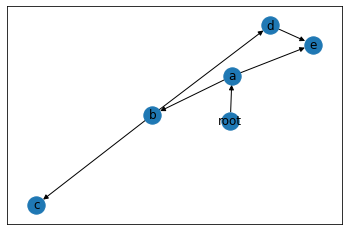

In [17]:
from matplotlib import pyplot as plt
g1 = nx.DiGraph()
g1.add_edges_from([("root", "a"), ("a", "b"), ("a", "e"), ("b", "c"), ("b", "d"), ("d", "e")])
plt.tight_layout()
nx.draw_networkx(g1, arrows=True)
plt.savefig("g1.png", format="PNG")
# tell matplotlib you're done with the plot: https://stackoverflow.com/questions/741877/how-do-i-tell-matplotlib-that-i-am-done-with-a-plot
plt.clf

# using Google maps

In [13]:
import numpy as np
import pandas as pd
import pulp
import itertools
import gmaps
import googlemaps
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import output
output.enable_custom_widget_manager()




/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Vehicle Requirements: 3
Moving Distance: 14589.0


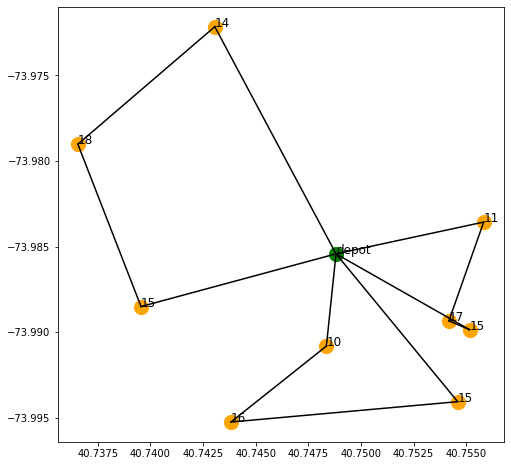

In [14]:
API_KEY = 'put your key here'
gmaps.configure(api_key=API_KEY)
googlemaps = googlemaps.Client(key = API_KEY

# customer count ('0' is depot) 
customer_count = 10

# the number of vehicle
vehicle_count = 4

# the capacity of vehicle
vehicle_capacity = 50

# fix random seed
np.random.seed(seed=777)

# set depot latitude and longitude
depot_latitude = 40.748817
depot_longitude = -73.985428

# make dataframe which contains vending machine location and demand
df = pd.DataFrame({"latitude":np.random.normal(depot_latitude, 0.007, customer_count), 
                   "longitude":np.random.normal(depot_longitude, 0.007, customer_count), 
                   "demand":np.random.randint(10, 20, customer_count)})

# set the depot as the center and make demand 0 ('0' = depot)
df.iloc[0,0] = depot_latitude

#df.longitude.iloc[0] = depot_longitude
#df.demand.iloc[0] = 0

df.iloc[0,1] = depot_longitude
df.iloc[0,2] = 0

#df.iloc[0,0].longitude = depot_longitude
#df.iloc[0,0].demand = 0

# function for plotting on google maps
def _plot_on_gmaps(_df):
    
    _marker_locations = []
    for i in range(len(_df)):
        _marker_locations.append((_df['latitude'].iloc[i],_df['longitude'].iloc[i]))
    
    _fig = gmaps.figure()
    _markers = gmaps.marker_layer(_marker_locations)
    _fig.add_layer(_markers)

    return _fig

# function for calculating distance between two pins
def _distance_calculator(_df):
    
    _distance_result = np.zeros((len(_df),len(_df)))
    _df['latitude-longitude'] = '0'
    for i in range(len(_df)):
        _df['latitude-longitude'].iloc[i] = str(_df.latitude[i]) + ',' + str(_df.longitude[i])
    
    for i in range(len(_df)):
        for j in range(len(_df)):
            
            # calculate distance of all pairs
            _google_maps_api_result = googlemaps.directions(_df['latitude-longitude'].iloc[i],
                                                            _df['latitude-longitude'].iloc[j],
                                                            mode = 'driving')
            # append distance to result list
            _distance_result[i][j] = _google_maps_api_result[0]['legs'][0]['distance']['value']
    
    return _distance_result

distance = _distance_calculator(df)
plot_result = _plot_on_gmaps(df)
plot_result


# solve with pulp
for vehicle_count in range(1,vehicle_count+1):
    
    # definition of LpProblem instance
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # definition of variables which are 0/1
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]

    # add objective function
    problem += pulp.lpSum(distance[i][j] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count) 
                          for j in range(customer_count) 
                          for i in range (customer_count))

    # constraints
    # foluma (2)
    for j in range(1, customer_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                              for i in range(customer_count) 
                              for k in range(vehicle_count)) == 1 

    # foluma (3)
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

    # foluma (4)
    for k in range(vehicle_count):
        for j in range(customer_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                  for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

    #foluma (5)
    for k in range(vehicle_count):
        problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= vehicle_capacity 


    # fomula (6)
    subtours = []
    for i in range(2,customer_count):
         subtours += itertools.combinations(range(1,customer_count), i)

    for s in subtours:
        problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1

    
    # print vehicle_count which needed for solving problem
    # print calculated minimum distance value
    if problem.solve() == 1:
        print('Vehicle Requirements:', vehicle_count)
        print('Moving Distance:', pulp.value(problem.objective))
        break
        
        



# visualization : plotting with matplolib
plt.figure(figsize=(8,8))
for i in range(customer_count):    
    if i == 0:
        plt.scatter(df.latitude[i], df.longitude[i], c='green', s=200)
        plt.text(df.latitude[i], df.longitude[i], "depot", fontsize=12)
    else:
        plt.scatter(df.latitude[i], df.longitude[i], c='orange', s=200)
        plt.text(df.latitude[i], df.longitude[i], str(df.demand[i]), fontsize=12)

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df.latitude[i], df.latitude[j]], [df.longitude[i], df.longitude[j]], c="black")

plt.show()

In [21]:
# visualization : plotting on google maps
fig = gmaps.figure()
layer = []
color_list = ["red","blue","green"]

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                layer.append(gmaps.directions.Directions(
                    (df.latitude[i],df.longitude[i]),
                    (df.latitude[j],df.longitude[j]),
                    mode='car',stroke_color=color_list[k],stroke_opacity=1.0, stroke_weight=5.0))

for i in range(len(layer)):
    fig.add_layer(layer[i])
    
fig

Figure(layout=FigureLayout(height='420px'))

In [18]:
fig

Figure(layout=FigureLayout(height='420px'))